In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from model import *
from pickle_cache import PickleCache
import pandas as pd
from experiment_widgets import VariableTracingExperiment
import json
from random import sample, randint, choices
import string
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

pcache = PickleCache()

In [11]:
all_names = string.ascii_lowercase
all_operators = ['+', '-']

def generate_trial(N):
    names = sample(all_names, k=N)
    variables = [
        {'variable': names[i], 'value': randint(1, 9)}
        for i in range(N)
    ]

    expr_var_order = sample(variables, k=len(variables))
    operators = choices(all_operators, k=N-1)
    expr_list = []
    expr_value = expr_var_order[0]['value']
    for i in range(N):
        if i > 0:
            op = operators[i-1]
            expr_value = eval(f"{expr_value} {op} {expr_var_order[i]['value']}")
            expr_list.append(op)
        expr_list.append(expr_var_order[i]['variable'])
    expr = ' '.join(expr_list)
    
    return {
        'variables': variables, 
        'expression': expr,
        'expression_value': expr_value
    }

def exp_name(N_var, N_trials):
    return f'vartrace_{N_var}_{N_trials}'

In [80]:
N_var = 7
N_trials = 10

experiment = {
    'trials': [generate_trial(N_var) for _ in range(N_trials)],
    'between_trials_time': 1000
}

exp = VariableTracingExperiment(experiment=json.dumps(experiment), results='[]')

def on_result_change(_):
    pcache.set(exp_name(N_var, N_trials), {
        'experiment': experiment,
        'results': json.loads(exp.results)
    })
    
#exp.observe(on_result_change)

exp

VariableTracingExperiment(experiment='{"trials": [{"variables": [{"variable": "i", "value": 6}, {"variable": "…

In [63]:
def process_results(N_var, N_trials):
    data = pcache.get(exp_name(N_var, N_trials))
    experiment = data['experiment']
    results = data['results']
    
    df = []
    for (trial, result) in zip(experiment['trials'], results):
        try:
            response = int(result['response'])
        except ValueError:
            response = -1000
                   
        correct = trial['expression_value'] == response
        df.append({
            'N_var': N_var,
            'correct': correct,
            'switches': result['switch_count']//2,
            'response_time': result['response_time']/1000.
        })
    return pd.DataFrame(df)

process_results(N_var, N_trials)

,N_var,correct,switches,response_time
0,7,True,3,25.240
1,7,True,1,20.318
2,7,False,2,18.790
3,7,True,3,24.138
4,7,True,2,26.821
5,7,True,1,13.549
6,7,True,1,15.813
7,7,True,1,11.606
8,7,True,3,35.147
9,7,True,1,18.842


In [64]:
all_exp = [2, 3, 4, 5, 6, 7]
results = pd.concat([process_results(N_var, 10) for N_var in all_exp])

Text(0, 0.5, 'Response time (s)')

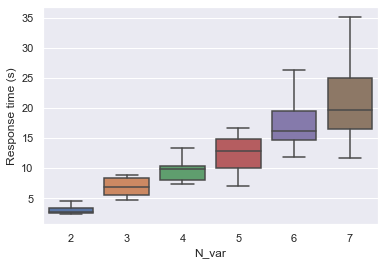

In [67]:
ax = sns.boxplot(data=results, x='N_var', y='response_time')
ax.set_ylabel('Response time (s)')

In [107]:
import statsmodels.formula.api as smf
data = results.groupby('N_var').response_time.nlargest(2).reset_index().groupby('N_var').mean().reset_index()
smf.ols('response_time ~ np.power(N_var,2)', data=data).fit().summary()

/Users/will/Code/psypl-experiments/.env/lib/python3.7/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          response_time   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     343.8
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           4.98e-05
Time:                        19:09:54   Log-Likelihood:                -8.4676
No. Observations:                   6   AIC:                             20.94
Df Residuals:                       4   BIC:                             20.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8873      0.889      3.246      0.031       0.418       5.357
np.power(N_var, 2)     0.5909      0.032     18.543      0.000       0.502       0.679
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.144
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.544
Skew:                           0.489   Prob(JB):                        0.762
Kurtosis:                       1.896   Cond. No.                         50.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

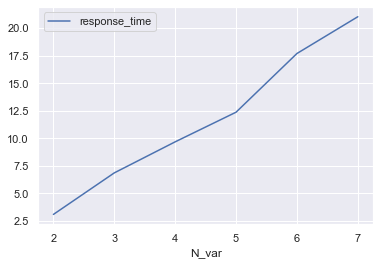

In [71]:
results.groupby('N_var').mean().plot(y='response_time')

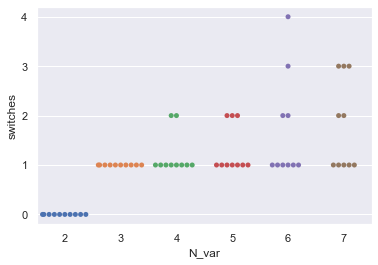

In [70]:
ax = sns.swarmplot(data=results, x='N_var', y='switches')
ax.set_yticks(list(range(5)))

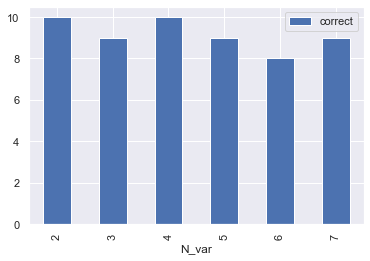

In [47]:
results.groupby('N_var').sum().plot.bar(y='correct')

In [60]:
def model(trial):
    wm = WorkingMemory()
    
    
    
#     for var in trial['variables']:
#         wm.store_var_val(var['variable'], var['value'])
        
#     expr = parse(trial['expression']).statements[0].value
#     return trace_expr(expr, wm) == trial['expression_value']

trial = generate_trial(5)
model(trial)

# df = []
# for N_var in all_exp:
#     #data = pcache.get(exp_name(4, N_trials))
#     #trials = data['experiment']['trials']
#     trials = [generate_trial(N_var) for _ in range(1000)]
#     correct = 0
#     for trial in trials:
#         correct += 1 if model(trial) else 0
#     df.append({
#         'N_var': N_var,
#         'correct': correct / len(trials)
#     })
# plot_results(pd.DataFrame(df))

{'variables': [{'variable': 'n', 'value': 7}, {'variable': 'u', 'value': 1}, {'variable': 'r', 'value': 9}, {'variable': 'a', 'value': 7}, {'variable': 'o', 'value': 4}], 'expression': 'u - n + a + r + o', 'expression_value': 14}
